 # Learning large causal structural models

A short introduction into *structural causal models* and an overview of techiques based on deep learning to learn them. With *large* we mean *many nodes*.


Author: Tobias Windisch (http://www.tobias-windisch.de)

In [1]:
from networkx import DiGraph
import matplotlib.pyplot as plt
import networkx as nx 
import pandas as pd
import numpy as np

The following examples are taken from Schölkopf et al., 2021, *Towards causal representation learning*

## Whats causality?
With data from all countries, one can compute that the number of storks $S$ in a country correlates with the birth rate $B$ and its possible to estimate the birth rate of a country given its stork rate. However, there is no direct *causal* relation!

From observational data, we cannot conclude whether storks bring the babies $S\to B$, or babies attract storks $B\to S$, or there is a hidden information $H$ (like economic development) so that $S\leftarrow H\rightarrow B$

## Why?

Typical supervised learning deals with approximating a conditional distribution, i.e.,

$$f(Y=y|X=x)$$

often using observations $(x_1, y_1), \ldots, (x_n, y_n)$ where one assumes they are iid samples from $f$.




Conditional distributions help answering questions like these:

* Whats the probability that this particular image $x$ contains a dog?
* Whats the probability of heart failure given this diagnostic measurement $x$?
* Whats the probability that a manufactured component with quality measurements $x$ become scrap?
* Whats the birth rate in a country given a stork rate $x$?


### Going beyond prediction
However, a lot of interesting questions don't fit into that scheme:

* Whats happens to the scrap probability if we tighten the tolerance of one particular measurement?
* Would a scrap part with measurements $x$ be OK if we change $x_i=7$?

## Conditional density distributions

Given random variables $X_1, X_2, \ldots, X_d$, then the **conditional density distribution** is

$$f_{X_1|X_2,\ldots,X_d}(x_1|x_2\ldots, x_d):=\frac{f_{X_1}(x_1)}{f_{X_2,\ldots, X_d}(x_2, \ldots, x_d)}$$

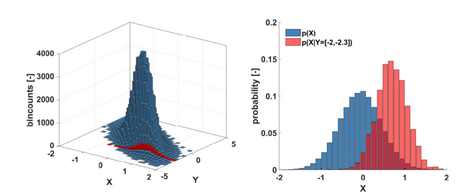


**Note**: For each selection $x_2,\ldots, x_n$ the function $f_{X_1|X_2,\ldots,x_n}(\cdot|x_2\ldots, x_n)$ is a density function on $\mathbb{R}$


### Example

$$f_{X_1|X_2, X_3} (\cdot | x_2, x_3)= \mathcal{N}(x_2, x_3^2)$$

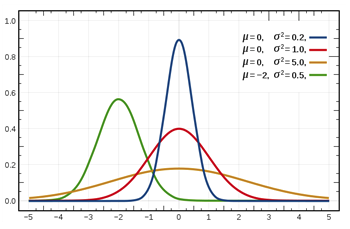




### Bayes rule
Given $f_{X_1|X_2,\ldots,X_d}$, one can compute:
$$\underbrace{f_{X_1}(x_1)}_{\mathbb{P}(A)} = \underbrace{f_{X_1|X_2,\ldots,X_d}(x_1|x_2\ldots, x_d)}_{\mathbb{P}(A|B)}\cdot \underbrace{f_{X_2,\ldots, X_d}(x_2, \ldots, x_d)}_{\mathbb{P}(B)}$$




## Whats a structural causal model?

Let $X_1, \ldots, X_d$ random  variables on $\mathbb{R}^d$. To explain what a structural causal model is, let us first explain its two ingredients, which are

* A directed acyclic graph whose nodes correspond to the random variables
* For each node of the graph a node model for for the conditional distribution of the respective variable



### Directed acyclic graphs (DAGs)

A DAG $G$ on $\{X_1,\ldots, X_d\}$ is a directed graph without directed cycles

In [2]:
small_dag = nx.DiGraph()
small_dag.add_nodes_from([f"$X_{i}$" for i in range(1, 6)])
small_dag.add_edges_from(
    [
        ("$X_2$", "$X_3$"), ("$X_4$", "$X_1$"), ("$X_4$", "$X_3$"), ("$X_3$", "$X_5$"), ("$X_1$", "$X_5$")
    ]
)

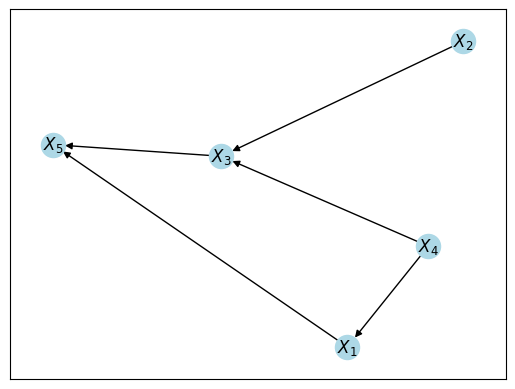

In [3]:
pos = nx.spring_layout(small_dag, seed=10)
nx.draw_networkx(small_dag, pos=pos, node_color='lightblue')

#### Parent of a node
For a node $i$, let $P_G(i)$ be its parent nodes (i.e, those nodes $j$ with directed edges into $i$)


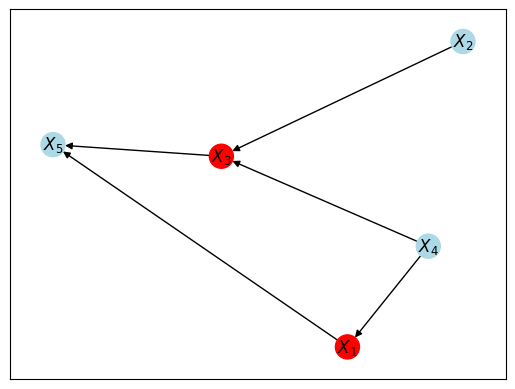

In [4]:
nx.draw_networkx(
    small_dag, 
    pos=pos, 
    node_color=['red' if n in ['$X_1$', '$X_3$'] else 'lightblue' for n in small_dag.nodes]
)

### Node functions

For each $i$, a function $f_i$ exists so that

$$X_i=f_i(X_j: j\in P_G(i), \epsilon_i)$$

where $\epsilon_1,\ldots,\epsilon_d$ are independent random variables ("noise").

For instance:

* $X_2 = \epsilon_2$ with $\epsilon_2\sim \mathcal{N}(0, 1)$
* $X_4 = \epsilon_4$ with $\epsilon_4\sim \mathcal{N}(1, 0.5)$
* $X_1 = 3\cdot X_4 \cdot\epsilon_1$ with $\epsilon_1\sim\mathcal{B}(0.5, 0.5)$
* $X_3 = 0.1\cdot X_2+ X_4 + \epsilon_3$ with  $\epsilon_3\sim\mathcal{N}(0, 1)$
* $X_5 = X_1^2\cdot X_3 + X_1+\epsilon_5$ with $\epsilon_5\sim\mathcal{B}(0.1, 0.9)$



**Note**: Structural causal models (SCM) are sometimes also called *structural equation models* (SEM) or *Bayesian networks* (BN)

**Remark**: The way how the noises $\epsilon_i$ go into the equations changes a lot. Typically, additive noise (gaussian) noise is assumed

Now, the joint density function can be obtained using Bayes rule along the paths in the topological order in $G$:

$$f^G(x_1,\ldots,x_d):=\prod_{i=1}^d P(X_i=x_i | X_j=x_j, j\in P_G(i))$$

For the graph from above

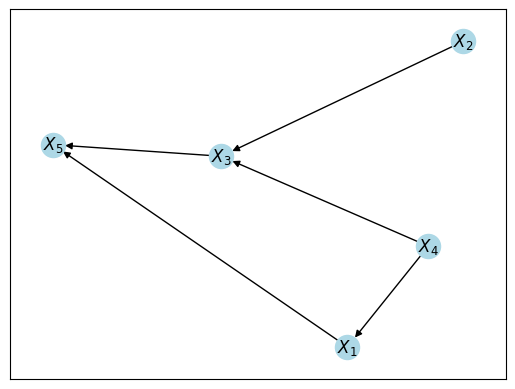

In [5]:
nx.draw_networkx(small_dag, pos=pos, node_color='lightblue')

Understanding the "complicated" density distribution on $\mathbb{R}^5$ now boils down to understand the simpler distributions:

$$f^G(x_1,\ldots,x_d):=P(X_5=x_5 | X_1=x_1, X_3=X_3)\cdot \cdot P(X_3=x_3 | X_2=x_2, X_4=x_4)\\\cdot P(X_1=x_1 | X_4=x_4)\cdot P(X_4=x_4) \cdot P(X_2=x_2)$$

### Confounders

$X_1$ and $X_3$ correlate, but there there is no direct causal effect. Both are causally influenced by $X_4$ (a confounder). Challenging situations are when confounders are *hidden*, i.e., if they cannot be observed 

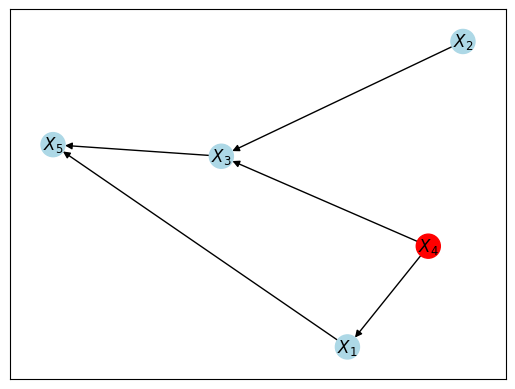

In [6]:
nx.draw_networkx(small_dag, pos=pos, node_color=['red' if n in ['$X_4$'] else 'lightblue' for n in small_dag.nodes])

## What can be done having a structual causal model?

Having a SCM for a system of jointly distributed random variables $X_1, \ldots, X_d$, a bunch of statistical questions about the data can be answered using properties of the DAG. For instance

* We can read off the DAG which variables are (in)dependent from each other (conditional independence statements)
* We can read off directions of influences and check long influence chains
* We find important variables that have a lot of influence onto others
* We can compare graphs for different datasets and find fundamental differences
* We can intervene (i.e., setting some $X_i$ to a fixed value)
* We can compute average causal effects

## How to get a structural causal model?

... say when $X_1, \ldots, X_d$ are some observable random variables and we want to understand the density function $f$ where $f(x_1, \ldots, x_d)$ is the likelihood of observing the incarnation $(x_1, \ldots, x_d)$.

### Questions to be answered

* What is `G`?
* What are the conditional distributions on the nodes of `G`?


Generally, we are the following (extreme) szenarious how to answer those questions:
* Option A: There exist experts who know exactly how the random variables relate to each other and they can just "write down" `G`  and all its conditional distributions
* Option B: Nobody has any clue but we have tons of observations and we can use the network using statistics and machine learning

Of course, there are also options in between :-). Nevertheless, lets discuss option B for the remainder

## Learning structural causal models form observational data




### ... with known DAG

Assume we know `G`. Then we "just" have to learn the conditional functions $f_{X_i|P_G(X_i)}(\cdot|x_j: j\in P_G(i))$ from data, like by using parametrized probability models and using an maximum ilkelihood approach:


That is, given a parametrized family of functions $g^i_\theta:\mathbb{R}^{P(i)}\to\mathbb{R}$ for all $i\in [d]$ we want $\theta^*$ such that

$$g^i_{\theta^*}(x_j: j\in P_G(i)) \approx f_{X_i|P_G(X_i)}(\cdot|x_j: j\in P_G(i))$$


The $g^i$'s can be learned using standard supervised learning methods.



### ... with unkown DAG

Challenge here: A DAG is a mathematical object that cannot easily be parametrized, and hence optimization over it results into **NP-hard** problems.

But can we try them just all? Well, good luck, there are 
$$\sum_{k=1}^d(-1)^{k+1}\binom{d}{k}2^{k\cdot (d-k)}\cdot G(d-k)$$
many DAGs on $d$ nodes. Already for $d=10$: $4.2\cdot 10^{18}$ many DAGs. 

For high-dimensional data, like from manufacturing processes, we often have: $d=1000$ => We are f***ed :-)


There are some workarounds, but they all suffer from the curse of dimensionality and one cannot hope for convergence (in reasonable time).

Here, methods to learn the structure are typically distinguished into

* Combinatorial methods: Methods that learn the (graph-)structure first and then do maximum likelihood estimation
* Continiuous methods: Methods that learn both structure and model-parameters at the same time 

## DAGs with NOTEARs



NOTEARs stands for ***N**on-combinatorial **O**ptimization via **T**race **E**xponential and **A**ugmented lag**r**angian for **S**tructure learning* (well, the name seems a bit doctored, right?) and the algorithm behind was first described in [arXiv:1803.01422](https://arxiv.org/abs/1803.01422). 


### Core idea

The basic idea is to reformulate the
combinatorial problem of finding a DAG for a problem to a continious
problem as follows: Let $x\in\mathbb{R}^d$ be a single datapoint and assume that the function

$$g^i_\theta(x_1, \ldots,x_{i-1},x_{i+1}, \ldots, x_d)$$

tries to estimate $x_i$ by using **all other features** as input.

 Now, if for a certain parameter $\theta$, $g^i_\theta$ "does not depend on $x_j$", then $X_i$ does not depend on $X_j$.

* That means, there is no edge from $j$ to $i$ 


One can formalize the "does not depend on" by requiring the partial derivative 

$$\frac{\partial g_\theta^i}{\partial x_j}:\mathbb{R}^{d-1}\to\mathbb{R}^\mathbb{R}$$

to be the is the zero function (that is, zero for all elements of $\mathbb{R}^{d-1}$). 

#### Example
For instance, if 

$$g^3_{\theta_1, \theta_2}(x_1, x_2) =  \theta_1x_1 + \theta_2x_2$$

then $g^3_{\theta_1, \theta_2}$ does not depend on $x_1$ if and only if $\theta_1=0$


**Note:** Actually, we want to model a distribution of $X_i$ given all other features and everything above (and below) can also be formulated so that the output of $g_\theta^i$ are the parameters of a distribution of $X_i$

### An adjacency matrix
Now, define the parametrizd $d\times d$ matrix $W$ as

$$W(\theta)_{i,j}:=\left\|\frac{\partial g_\theta^i}{\partial x_j}\right\| $$

where $\|\cdot\|$ denotes a function norm, then

* there is no edge from $j$ to $i$ if $W(\theta)_{i,j}=0$.


That means, $W(\theta)$ encodes a graph on $\{X_1,\ldots, X_d\}$ for each parameter!



So what have we won? Actually, nothing so far. The magic now comes from the following result (see Theorem 1 in [arXiv:1803.01422](https://arxiv.org/abs/1803.01422)):

   **Lemma:** A directed graph with adjacency matrix $W\in\mathbb{R}^{d\times d}$ is acyclic if and only if
   $\text{trace}\left(\exp(W)\right)=d$.

Lets check that for our `small_dag`

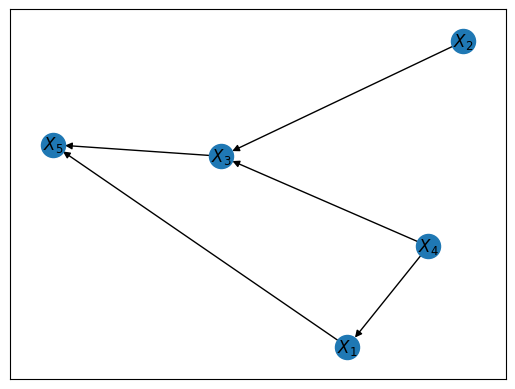

In [7]:
nx.draw_networkx(small_dag, pos=pos)

In [8]:
W = nx.convert_matrix.to_numpy_matrix(small_dag)
W

matrix([[0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [9]:
from scipy.linalg import expm

In [10]:
expm(W)

array([[1. , 0. , 0. , 0. , 1. ],
       [0. , 1. , 1. , 0. , 0.5],
       [0. , 0. , 1. , 0. , 1. ],
       [1. , 0. , 1. , 1. , 1. ],
       [0. , 0. , 0. , 0. , 1. ]])

In [11]:
np.trace(expm(W)) - 5.0

0.0

So, no cycle in `small_graph`!

### Optimization problem of NOTEARs

Ok, to put everything together, we have to solve the following **continiuous** optimization problem:

$$\min_{\theta\in\Theta}\sum_{x\in D}\sum_{i=1}^d |g^i_{\theta_i}(x_1, \ldots,x_{i-1},x_{i+1}, \ldots, x_n)- x_i|^2\quad\text{ such that }\quad\text{trace}\left(\exp(W(\theta))\right)-d=0$$


### Linear node models

In case all $g^i_{\theta_i}$ are linear models, we can write down $W$ directly:


$$W(\theta_1, \ldots, \theta_d)=\begin{pmatrix}\cdots\theta_1\cdots \\ \vdots \\ \cdots\theta_d\cdots\end{pmatrix}\in\mathbb{R}^{d\times d}$$

More details can be found in the [NOTEARs paper](https://arxiv.org/abs/1803.01422)

### More flexible node models

As dependences between $X_i$ and its (true) parents can be arbitrarily complicated, arbitrarily flexible functions  $g_i^\theta$ are desired (aka Neural nets).


...mhh..wait a bit: What is $\frac{\partial g_\theta^i}{\partial x_j}$ when $g_\theta^i$ is a neural net?


Its (computationally) infeasible to compute (symbolically) the deriviate of a neural network and hence we have to look for sufficient (and hence stronger) conditions that imply that the partial derivative is zero. Here are two ideas:

* If the weights of the first layer that get multiplied with $x_j$ are all zero, then certainly the derivate is zero (this is published in [Learning Sparse Nonparametric DAGs](https://arxiv.org/abs/1909.13189)
* Analyse the connectivity in the neural network, more specifically: check whether the values of $x_j$ reach the final layer (this is from [Gradient-Based Neural DAG Learning](https://arxiv.org/abs/1906.02226)

### One question remains!

How to train neural networks so that their parameters satisfy certain quality constraints?

Answer: Use the [augmented lagrangian method](https://en.wikipedia.org/wiki/Augmented_Lagrangian_method)

$$\min_{\theta\in\Theta} g(\theta) \quad\text{ such that }\quad h(\theta)=0$$

   
by solving a series of unconstrained optimization problems that add a
pentalty term to the original problem. 
As in our case, $h$ maps to a one-dimensional space, the
augmented lagrangian method for this simplified version is as follows,
the $k$-th problem looks as folllows:

$$\min_{\theta\in\Theta}\left(g(\theta) + \frac{\rho_k}{2}\cdot h(\theta)^2 + \alpha_k\cdot h(\theta)\right)$$
   
Where $\rho_{k+1}=C\cdot\rho_k$ and $\alpha_{k+1} =
\alpha_k + \rho_k\cdot h(\theta_k)$, $\theta_k$ is the solution
to the $k$-th optimization problem.

## Causal Discovery solved?

There is still a lot work to do:
* [Causal discovery benchmarks may be too easy to game](https://arxiv.org/abs/2102.13647)
* [NOTEARs struggles with dimension quantities](https://link.springer.com/article/10.1007/s11063-021-10694-5)

### Large cycles are ignored!

In [12]:
def get_adjacency_of_cycle(length):
    return nx.to_numpy_array(nx.cycle_graph(length, create_using=nx.DiGraph))

In [13]:
W5 = get_adjacency_of_cycle(5)
np.trace(expm(W5))-5 == 0 

False

In [14]:
W10 = get_adjacency_of_cycle(10)
np.trace(expm(W10))-10 == 0

False

In [15]:
W20 = get_adjacency_of_cycle(20)
np.trace(expm(W20))-20 == 0

True

**WTF?!**


$$\text{exp}(W)=1+\sum_{i=1}^\infty\frac{W^k}{k!}$$

In [16]:
np.diag(expm(W20))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [17]:
from scipy.special import factorial

In [18]:
1+1/factorial(20) == 1

True

Trace of matrix exponent may not be good choice in practice! Other works, like NOBEARs use spectral information of the adjacency instead (like the largest eigenvalue).

### Many hyper parameters inhibit vanilla usage

In [19]:
from bn_testing.models import BayesianNetwork
from bn_testing.dags import ErdosReny
from bn_testing.conditionals import PolynomialConditional
from bn_testing.conditionals import LinearConditional
import pymc as pm

In [20]:
class SimpleConditional(LinearConditional):

    def make_source(self):
        return pm.Beta.dist(
            alpha=self.random.uniform(1, 5),
            beta=self.random.uniform(1, 5),
        )
        
    def make_noise(self):
        return pm.Beta.dist(
            alpha=self.random.uniform(1, 5),
            beta=self.random.uniform(1, 5),
        )

In [21]:
model = BayesianNetwork(
    dag=ErdosReny(n_visible_nodes=20, p=0.15),
    conditionals=SimpleConditional(),
    random_state=10,
)

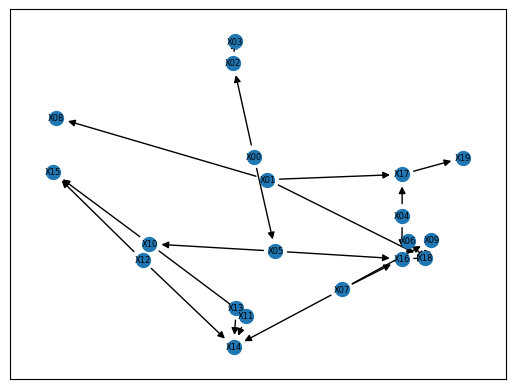

In [22]:
model.show()

In [23]:
df = model.sample(2000, normalize=True)

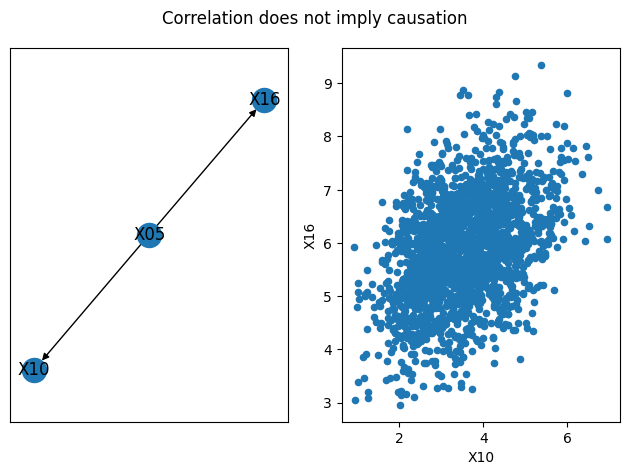

In [24]:
fig, axes = plt.subplots(ncols=2)

df.plot.scatter(x='X10', y='X16', ax=axes[1])

nx.draw_networkx(model.dag.subgraph(['X05', 'X10', 'X16']), ax=axes[0])
fig.suptitle('Correlation does not imply causation')
fig.tight_layout()

In [25]:
from causalnex.structure.notears import from_pandas

In [26]:
dag_learned = from_pandas(df, w_threshold=0.3, max_iter=200)

Text(0.5, 1.0, 'Learned')

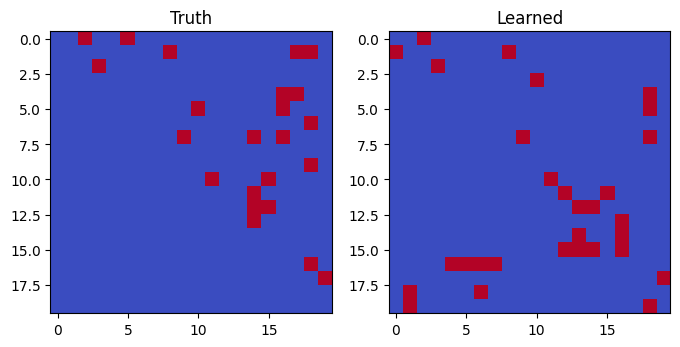

In [27]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

axes[0].imshow(nx.to_numpy_array(model.dag), cmap='coolwarm')
axes[0].set_title('Truth')

axes[1].imshow(nx.to_numpy_array(dag_learned) != 0, cmap='coolwarm')
axes[1].set_title('Learned')

And here the result of a method customized to this setting: [LINGAM](https://lingam.readthedocs.io/en/latest/tutorial/lingam.html#id5), a method to learn a linear, non-gaussian structural equation model (LINGAM)

In [28]:
import lingam

In [29]:
model_lingam = lingam.DirectLiNGAM()
model_lingam.fit(df)

Text(0.5, 1.0, 'Learned')

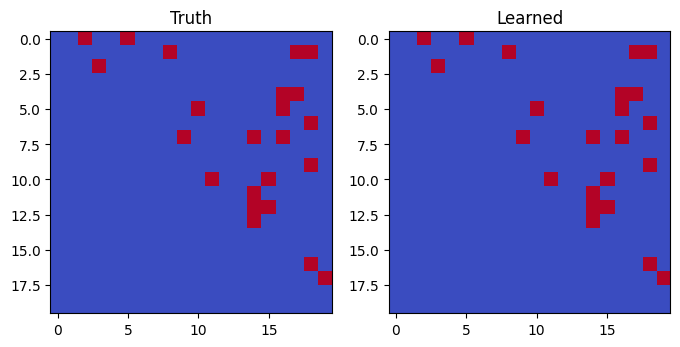

In [30]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

axes[0].imshow(nx.to_numpy_array(model.dag), cmap='coolwarm')
axes[0].set_title('Truth')

axes[1].imshow(model_lingam.adjacency_matrix_.T != 0, cmap='coolwarm')
axes[1].set_title('Learned')